In [1]:
# Load helpers and custom dataset class
from __init__ import PricingWizardDataset, regression_accuracy, threshold_accuracy

# Data manipulation 
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.utils.data import Dataset, TensorDataset

In [2]:
# Data loading
data = PricingWizardDataset(
    filename = 'post_preprocessing_without_dummies.csv'
)

Dataset Loaded: post_preprocessing_without_dummies
	Number of Rows: 283055
	Number of Columns: 22
	Outlier Removal: True
	Train Size: 0.8
	Test Size: 0.2
	Random State: 42


In [3]:
# Function to return data without clasiified_id
drop_helpers = lambda x: x.loc[:, (x.columns != 'classified_id') & (x.columns != 'listing_price') & (x.columns != 'log_listing_price')] 

## Version 1
OneHotEncoding: Subsubsub Categories
Using:
- Average pricing for brands 
- Ordinal Encoding: Condition Name

In [37]:
# Reset dataset
data.reset_dataset()

# Ordinal Encoding for condition, since this typically follows some sort of order
condition_name = ['Shabby', 'Good but used','Almost as new', 'Never used', 'New, still with price']
data.df['condition_name'] = data.df['condition_name'].apply(lambda x: condition_name.index(x) + 1)

In [38]:
# Mapping rare brands categories to 'Other'. This is so we get a representive listing price to encode for the brand
minimum = 30
print(f'Number of brand categories with less than {minimum} listings:', sum(data.df.brand_name.value_counts() < minimum), ' or ', round(sum(data.df.brand_name.value_counts() < minimum) / len(data.df) * 100, 2), '% of dataset')

rare_brands = pd.DataFrame(data.df.brand_name.value_counts()).where(data.df.brand_name.value_counts() < minimum).dropna().index

# Mapping rare brandsub categories to 'Other' (those with less than 30 listings or around 0.01%
data.df['brand_name'] = data.df['brand_name'].apply(lambda x: 'Other' if x in rare_brands else x)

Number of brand categories with less than 30 listings: 220  or  0.08 % of dataset


In [39]:
# # Encoding brand_name based on average listing price
brand_encoding = data.df.groupby('brand_name').agg({'log_listing_price': 'mean'}).sort_values(by='log_listing_price', ascending=True).to_dict()['log_listing_price']

# # Convert condition_name to ordinal
data.df['brand_name'] = data.df['brand_name'].apply(lambda x: brand_encoding[x])

In [40]:
# Similarly as brand, just for subsubsubsub categories
minimum = 30
print(f'Number of subsubsub categories with less than {minimum} listings:', sum(data.df.subsubsubcategory_name.value_counts() < minimum), ' or ', round(sum(data.df.subsubsubcategory_name.value_counts() < minimum) / len(data.df) * 100, 2), '% of dataset')

rare_sub_categories = pd.DataFrame(data.df.subsubsubcategory_name.value_counts()).where(data.df.subsubsubcategory_name.value_counts() < minimum).dropna().index

Number of subsubsub categories with less than 30 listings: 146  or  0.05 % of dataset


In [41]:
# Replacing with subcategory name
data.df.loc[data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].index, 'subsubsubcategory_name'] = data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].subsubcategory_name

In [42]:
# Testing if there are any subsubsubsub categories left
minimum = 20 
print(f'Number of subsubsub categories with less than {minimum} listings:', sum(data.df.subsubsubcategory_name.value_counts() < minimum), ' or ', round(sum(data.df.subsubsubcategory_name.value_counts() < minimum) / len(data.df) * 100, 2), '% of dataset')
rare_sub_categories = pd.DataFrame(data.df.subsubsubcategory_name.value_counts()).where(data.df.subsubsubcategory_name.value_counts() < minimum).dropna().index
rare_sub_categories

Number of subsubsub categories with less than 20 listings: 0  or  0.0 % of dataset


Index([], dtype='object')

In [43]:
# Columns to use for model
columns_to_use = ['classified_id', 'log_listing_price','condition_name', 'brand_name', 'subsubsubcategory_name']

# Drop unused columns
data.df = data.df[columns_to_use]

# OHE
data.apply_function(pd.get_dummies, columns=['subsubsubcategory_name'])

In [44]:
# Preprocessing
scaler = MinMaxScaler()
X = scaler.fit_transform(drop_helpers(data.df))

In [45]:
# Assigning X to data.df
data.df[drop_helpers(data.df).columns] = X

In [46]:
# Splitting dataset
X_train, X_test, X_val, y_train, y_test, y_val = data.stratify_train_test_split(val_size=0.2, return_splits=True, y_column='log_listing_price')

# Converting to PyTorch tensors
X_train_tensor = torch.tensor(drop_helpers(X_train).to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(drop_helpers(X_test).to_numpy(), dtype=torch.float32)
X_val_tensor = torch.tensor(drop_helpers(X_val).to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create pytorch datasets
trainset = TensorDataset(X_train_tensor, y_train_tensor)
valset = TensorDataset(X_val_tensor, y_val_tensor)
testset = TensorDataset(X_test_tensor, y_test_tensor)

# Create pytorch dataloaders
batch_size = 32 
train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=testset, batch_size=1, shuffle=False)

Dependent variable distribution is equal across all subsets


### Model Helper Functions

In [47]:
def train_step(model, criterion, optimizer, train_loader, device):
    """
    Trains the model for one epoch.
    """
    # Set model to train mode
    model.train()
    
    # Save loss
    losses = []
    
    # Iterate over train_loader
    for i, data in enumerate(train_loader):
        
        # Extracting data and labels + moving to device
        input, labels = data
        input = input.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        y_hat = model(input).squeeze()
        
        # Compute loss
        loss = criterion(y_hat, labels)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Save loss
        losses.append(loss.item())
    
    # Return loss
    return losses


def validation(model, validation_loader, criterion, device):
    """
    Performs a validation step.
    """
    # Set model to eval mode
    model.eval()
    
    # Save loss
    losses = []
    
    # Iterate over train_loader
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            # Extracting data and labels + moving to device
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward pass
            y_hat = model(inputs).squeeze()

            # Compute loss
            loss = criterion(y_hat, targets)
            
            # Save loss
            losses.append(loss.item())
    
    # Return loss
    return losses

def train(model, criterion, optimizer, train_loader, validation_loader, device, epochs=100, print_every=1, early_stopping=5):
    # Train method
    train_losses = []
    val_losses = []
    
    train_accuracies = {
        'r2': [],
        'mse': [],
        'mae': [],
        'rmse': []
    }
    
    # Early stopping
    epochs_no_improve = 0
    min_val_loss = np.Inf
    
    for epoch in range(epochs):
        # Train step
        train_loss = train_step(model, criterion, optimizer, train_loader, device)
        train_loss = np.mean(train_loss)
        train_losses.append(train_loss)
        
        # Validation step
        val_loss = validation(model, validation_loader, criterion, device)
        val_loss = np.mean(val_loss)
        val_losses.append(val_loss)
        
        # Print loss
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, train loss: {train_loss}, val loss: {val_loss}')
        
        # Early stopping
        if val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve == early_stopping:
            print('Early stopping!')
            break
    
    return train_losses, val_losses

def test(model, validation_loader, criterion, device):
    """
    Performs a test step.
    """
    # Set model to eval mode
    model.eval()
    
    # Save loss
    losses = []
    
    # Iterate over train_loader
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            # Extracting data and labels + moving to device
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            
            # Forward pass
            y_hat = model(inputs).squeeze()

            # Compute loss
            loss = criterion(y_hat, targets)

            # Save loss
            losses.append(loss.item())
    
    # Return loss
    return y_hat

In [48]:
# Save model
def save_model(model, path):
    torch.save(model.state_dict(), path)

### Model

In [49]:
# Neural network
class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1))

    def forward(self, x):
        return self.main(x)

In [50]:
# Get next batch
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

# Create model
model = RegressionNN(x.shape[1])

# Print model summary
summary(model, input_size=x.shape[1])

# Pass data through model
y_pred = model(x)

print(y_pred.squeeze().shape)

torch.Size([32, 249])
torch.Size([32])
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       64,000
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       65,792
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       32,896
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       129
Total params: 162,817
Trainable params: 162,817
Non-trainable params: 0
torch.Size([32])


In [51]:
# Set device
device = torch.device('mps')

# Initialize the network
model = RegressionNN(input_size = x.shape[1])
model = model.to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Train model
train_losses, val_losses = train(model, criterion, optimizer, train_loader, val_loader, device, epochs=100, print_every=1, early_stopping=5)


Epoch 0, train loss: 1.188546820425098, val loss: 0.4453536680525979
Epoch 1, train loss: 0.43142929039727096, val loss: 0.4257126679359856
Epoch 2, train loss: 0.4212859832789095, val loss: 0.42003559132585416
Epoch 3, train loss: 0.41713058217916393, val loss: 0.4170200022516278
Epoch 4, train loss: 0.41463609116984296, val loss: 0.4149899010520197
Epoch 5, train loss: 0.412793128676123, val loss: 0.4133804127068843
Epoch 6, train loss: 0.41124120458522595, val loss: 0.4119716048787879
Epoch 7, train loss: 0.4098612189843139, val loss: 0.41070670896330796
Epoch 8, train loss: 0.40861111004312595, val loss: 0.4095239338775476
Epoch 9, train loss: 0.4074412824637969, val loss: 0.40842054721999305
Epoch 10, train loss: 0.40633776213358963, val loss: 0.40735374668055335
Epoch 11, train loss: 0.40528467267656243, val loss: 0.40633594806248186
Epoch 12, train loss: 0.40430212047824127, val loss: 0.40541142452150414
Epoch 13, train loss: 0.40340119069715863, val loss: 0.40455395768338676
Ep

<Axes: >

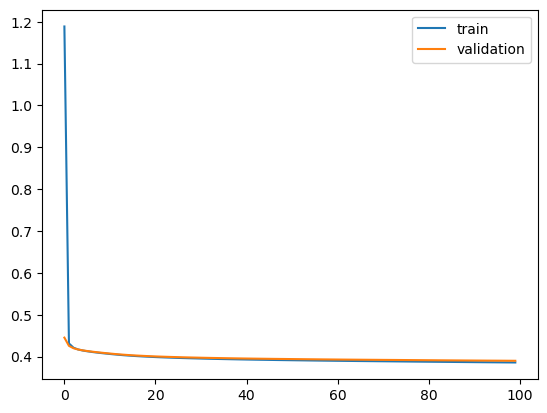

In [52]:
sns.lineplot(x=range(len(train_losses)), y=train_losses, label='train')
sns.lineplot(x=range(len(val_losses)), y=val_losses, label='validation')

##### Testset Evaluation

In [53]:
# Set model to eval mode
model.eval()

# Test model
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device))


# Convert to numpy
y_pred = y_pred.cpu().numpy().squeeze()

In [71]:
# Model Accuracy
print('Log Listing Price')
regression_accuracy(y_pred, y_test)
threshold_accuracy(y_pred, y_test, p=1)

# Upscaled
print('\n\nListing Price')
regression_accuracy(np.exp(y_pred), np.exp(y_test))
threshold_accuracy(np.exp(y_pred), np.exp(y_test), p=1)

Log Listing Price
R2 Score: 0.5978632097824663
MSE: 0.38745003142252527
MAE 0.4741426904467291
RMSE 0.6224548428782005
Threshold Accuracy 0.9998940135309392


Listing Price
R2 Score: 0.47108636060618536
MSE: 157293.09800940278
MAE 188.43992640234237
RMSE 396.60193898845574
Threshold Accuracy 0.8670046457402272


<Axes: >

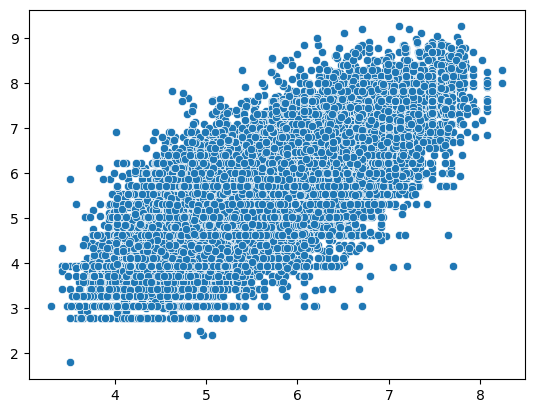

In [72]:
sns.scatterplot(x=y_pred, y=y_test)

Mean of residuals: -0.028755078478853658
Std of residuals: 0.621790299766891


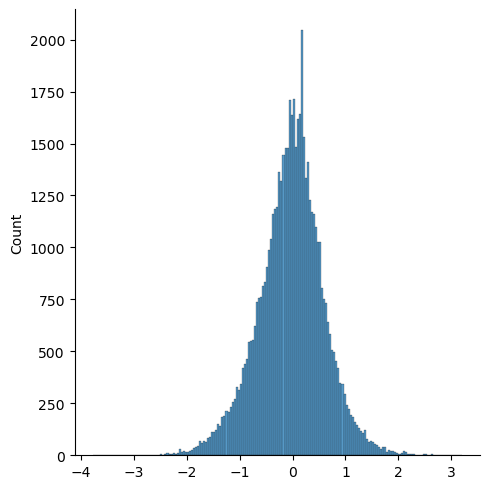

In [73]:
# Residuals
print('Mean of residuals:', np.mean(y_test - y_pred))
print('Std of residuals:', np.std(y_test - y_pred))
sns.displot(y_test - y_pred)
plt.show()

Generally we see the residuals behave as we'd like, but still sub-par performance and quite high standard deviation

In [74]:
# Save model
save_model(model, 'models/pickled_models/base_regression_net_log_price.pt')

#### Explore Differences

In [82]:
# Extract test data
test_data = data.raw_df[data.raw_df.classified_id.isin(X_test.classified_id)]

# Add predictions
X_test_copy = X_test.copy()
X_test_copy['log_listing_price'] = y_pred
X_test_copy['listing_price_prediction'] = np.exp(y_pred)

# Add predictions to test data
test_data = test_data.iloc[:, :14].merge(X_test_copy[['classified_id', 'log_listing_price', 'listing_price_prediction']], on='classified_id')

# Calculate difference
test_data['difference'] = test_data['listing_price'] - test_data['listing_price_prediction']
test_data['percentage_correct'] = (test_data['listing_price_prediction'] / test_data['listing_price']) 


In [80]:
# Explore
test_data.sort_values(by='difference', ascending=False).head(10)

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,category_name,subcategory_name,subsubcategory_name,subsubsubcategory_name,log_listing_price,listing_price_prediction,difference
15101,30493281,2023-09-14,1819766,5850,10500,13,125,Gucci,Good but used,Brown,Women,Women,Women,Crossbody bags,7.110592,1224.872314,9275.127686
44492,31227022,2023-10-19,2350675,6000,10000,0,32,Unassigned_Computere,"New, still with price",Grey,Electronics,Electronics,Electronics,Computere,6.707595,818.599854,9181.400146
4021,31488693,2023-11-02,2309769,5000,10000,10,167,Jordan,"New, still with price",Black,Men,Men,Men,Sneakers,7.217466,1363.030640,8636.969360
2064,31618256,2023-11-08,2228789,5000,9000,0,152,Jordan,Good but used,Brown,Men,Men,Men,Sneakers,6.510035,671.849609,8328.150391
31533,31598565,2023-11-07,1867625,7500,10500,11,168,Céline,Never used,Rust,Women,Women,Women,Crossbody bags,7.789734,2415.674561,8084.325439
28469,30867387,2023-10-02,2307950,1350,8056,1,57,Nike,Almost as new,Turquise,Men,Men,Men,Shoes,6.217467,501.431641,7554.568359
11994,31122380,2023-10-15,1057953,7000,9000,29,240,Louis Vuitton,Good but used,Brown,Women,Women,Women,Håndtasker,7.356691,1566.643799,7433.356201
31546,30393356,2023-09-09,2293983,7000,8000,0,22,Unassigned_Computere,Almost as new,Black,Electronics,Electronics,Electronics,Computere,7.019071,1117.747803,6882.252197
24338,31382457,2023-10-27,1298572,7500,8500,5,81,Moncler,Almost as new,Multi,Women,Women,Clothes,Down jackets,7.522018,1848.293335,6651.706665
16019,30369479,2023-09-08,1574523,7500,7500,6,46,Prada,Almost as new,Black,Women,Women,Women,Boots,6.783539,883.189087,6616.810913


In [85]:
test_data.sort_values(by='percentage_correct', ascending=False).head(10)

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,category_name,subcategory_name,subsubcategory_name,subsubsubcategory_name,log_listing_price,listing_price_prediction,difference,percentage_correct
21750,30396678,2023-09-10,1553782,50,50,8,219,Louis Vuitton,Never used,Orange,Women,Women,Women,Crossbody bags,7.704645,2218.628906,-2168.628906,44.372578
48615,31745558,2023-11-16,2304480,20,20,1,1,Unassigned_Computere,"New, still with price",Grey,Electronics,Electronics,Electronics,Computere,6.707595,818.599854,-798.599854,40.929993
45118,30558614,2023-09-17,2210278,20,20,0,0,Unassigned_Electronics,"New, still with price",Black,Electronics,Electronics,Electronics,Electronics,6.511746,673.000427,-653.000427,33.650021
19433,31572787,2023-11-06,2060059,50,50,0,1,Prada,Good but used,NaN,Women,Women,Women,Tasker,7.196636,1334.932129,-1284.932129,26.698643
17002,31508368,2023-11-03,2451185,30,30,3,16,66 North,Almost as new,Black,Women,Women,Women,Belts,6.678337,794.995605,-764.995605,26.499854
26556,31116495,2023-10-15,278280,20,20,3,29,Ikea,Good but used,Metallic,Home,Home,Furniture,Miscellaneous storage,6.204551,494.996765,-474.996765,24.749838
15687,30778328,2023-09-28,2516565,45,20,4,62,Adidas,Good but used,White,Men,Men,Men,Shoes,6.176340,481.227478,-461.227478,24.061374
5235,31949382,2023-11-29,58446,49,49,2,9,Apple,Good but used,White,Electronics,Electronics,Electronics,Parts & components,7.042089,1143.774414,-1094.774414,23.342335
46167,31454758,2023-10-31,2219468,40,40,1,9,Unassigned_Sneakers,"New, still with price",Black,Women,Women,Women,Sneakers,6.793024,891.605774,-851.605774,22.290144
32848,32044349,2023-12-05,377401,20,20,0,3,Nike,Almost as new,NaN,Men,Men,Men,Sneakers,6.071963,433.530792,-413.530792,21.676540


In [83]:
test_data.percentage_correct.describe()

count    56611.000000
mean         1.276809
std          1.079128
min          0.040808
25%          0.705745
50%          1.002018
75%          1.490773
max         44.372578
Name: percentage_correct, dtype: float64

### Alternative Encoding Approach

In [ ]:
data.reset_dataset()

# Ordinal Encoding for condition, since this typically follows some sort of order
condition_name = ['Shabby', 'Good but used','Almost as new', 'Never used', 'New, still with price']

# Encoding brands so most popular brands have the highest and vice versa. This is not the most appropriate method, as some brands are likely equal in price, and a better representation, taking in context could be used
brand_encoding = data.df.groupby('brand_name').agg({'log_listing_price': 'mean'}).sort_values(by='log_listing_price', ascending=True).to_dict()['log_listing_price']

# Dataframe
data.raw_df.iloc[:, :14].head()

In [ ]:
# Applying encoding (+1 to avoid 0)
data.df['brand_name'] = data.df['brand_name'].apply(lambda x: brand_encoding[x] + 1)
data.df['condition_name'] = data.df['condition_name'].apply(lambda x: condition_name.index(x) +1)

In [ ]:
# Mapping rare subsubsubsub categories to 'Other' (those with less than 30 listings or around 0.01%
minimum = 100
print(f'Number of subsubsub categories with less than {minimum} listings:', sum(data.df.subsubsubcategory_name.value_counts() < minimum), ' or ', round(sum(data.df.subsubsubcategory_name.value_counts() < minimum) / len(data.df) * 100, 2), '% of dataset')

rare_sub_categories = pd.DataFrame(data.df.subsubsubcategory_name.value_counts()).where(data.df.subsubsubcategory_name.value_counts() < minimum).dropna().index

In [ ]:
# Replacing with subcategory name
data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].subcategory_name.value_counts()

In [ ]:
# Applying transformation
data.df.loc[data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].index, 'subsubsubcategory_name'] = data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].subcategory_name

In [ ]:
# Ordinal encoding for subsubsubcategory_name
subsubsubcategory_encoding = data.df.groupby('subsubsubcategory_name').agg({'log_listing_price': 'mean'}).sort_values(by='log_listing_price', ascending=True).to_dict()['log_listing_price']

# Applying encoding
data.df['subsubsubcategory_name'] = data.df['subsubsubcategory_name'].apply(lambda x: subsubsubcategory_encoding[x])

data.df.head()

In [ ]:
### Columns used for regression
columns_to_use = ['classified_id','listing_price','brand_name','condition_name','subsubsubcategory_name']

# Drop unused columns
data.df = data.df[columns_to_use]

# # OHE. Will likely lead to too many columns
# data.apply_function(pd.get_dummies, columns = ['subsubsubcategory_name'])

# Print head
data.df.head()


In [ ]:
# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(drop_helpers(data.df))

# Assigning X to data.df
data.df[drop_helpers(data.df).columns] = X

In [ ]:
# Print head
data.df.head()

In [ ]:
# Split
X_train, X_test, X_val, y_train, y_test, y_val = data.stratify_train_test_split(val_size=0.2, return_splits=True, y_column='listing_price')

# Converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create pytorch datasets
trainset = TensorDataset(X_train_tensor, y_train_tensor)
valset = TensorDataset(X_val_tensor, y_val_tensor)
testset = TensorDataset(X_test_tensor, y_test_tensor)

# Create pytorch dataloaders
batch_size = 32
train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=testset, batch_size=1, shuffle=False)


##### Model

In [ ]:
# Neural network
class NewRegressionNN(nn.Module):
    def __init__(self, input_size):
        super(NewRegressionNN, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1))

    def forward(self, x):
        return self.main(x)

In [ ]:
# Get next batch
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

# Create model
model = NewRegressionNN(x.shape[1])

# Print model summary
summary(model, input_size=x.shape[1])

# Pass data through model
y_pred = model(x)

print(y_pred.squeeze().shape)

In [ ]:
# Train model
device = torch.device('mps')

# Initialize the network
new_model = NewRegressionNN(input_size = x.shape[1])
new_model = new_model.to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(new_model.parameters(), lr=0.001)

# Train new_model
new_train_losses, new_val_losses = train(new_model, criterion, optimizer, train_loader, val_loader, device, epochs=100, print_every=1, early_stopping=5)


In [ ]:
sns.lineplot(x=range(len(new_train_losses)), y=new_train_losses, label='train')
sns.lineplot(x=range(len(new_val_losses)), y=new_val_losses, label='validation')

In [ ]:
# Test Prediciotn and Accuracy
# Set model to eval mode
new_model.eval()

# Test model
with torch.no_grad():
    y_pred = new_model(X_test_tensor.to(device))
    
# Convert to numpy
y_pred = y_pred.cpu().numpy().squeeze()

# Model Accuracy
regression_accuracy(y_test, y_pred)

In [ ]:
# Residuals
print('Mean of residuals:', np.mean(y_test - y_pred))
print('Std of residuals:', np.std(y_test - y_pred))

sns.displot(y_test - y_pred)
plt.show()


### More Columns